# EID 444 Homework 4

# Modified Displacement Function (w/ Shift function))

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
import time

%pip install pymbar
import pymbar.timeseries as pt


#[1] https://stackoverflow.com/questions/29241056/how-do-i-use-np-newaxis

#R is a matrix of particle positions for N L-J particles

def shift(R, L):
    '''Adding periodic boundary conditions'''
    R = R - np.round(R/L) * L
    return R

def displacements(R, L):
    '''Calculates all displacements between all pairs 
    of particles'''


    #Computes the pairwise displacements: r_i - r_j
    #[1] - Learned about np.newaxis to help conduct matrix operations without consuming much memory
    dR = R[:, np.newaxis, :] - R[np.newaxis, :, :]
    #Wrapping positions under periodic boundary conditions
    dR_wrapped = shift(dR, L)

    return dR_wrapped


Note: you may need to restart the kernel to use updated packages.


# LJ Forces Function

In [51]:
def lj_forces(dR, sigma, epsilon):

     rij = np.linalg.norm(dR, axis=-1) #Uses wrapped trajectory
     FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation
     FRR[np.isnan(FRR)] = 0 #Shown to me by Jared

     return FRR


# Net Forces

In [52]:
def net_forces(FRR):
    FR = np.nansum(FRR, axis=1) #Shown to me by Jared. Had an issue where I could not get rid of nan values
    return FR

# Verlet Step

In [53]:
def verlet_step(r_current, r_prev, t, m, FR):
    """ Calculate the Verlet step of the Leonard-Jones particle system. """

    acceleration = FR / m[:, np.newaxis]  

    r_next = (2 * r_current) - r_prev + (acceleration * (t**2))

    return r_next 



# Simulation

In [54]:
#Credit to Jared for telling me to create a function that combines all previous functions


def Force_from_displacement(R, sigma, epsilon, L):
    dR_wrapped = displacements(R, L)
    Forces = lj_forces(dR_wrapped, sigma, epsilon)
    net_force = np.nansum(Forces[..., np.newaxis] * dR_wrapped, axis=0) 
    net_force[np.isnan(net_force)] = 0
    return net_force


def simulation(R_0, v_0, m, t, t_max, sigma, epsilon, L):
    t_start = time.time()


    n_steps = int(t_max / t)
    N = len(R_0)

    #Initialize trajectory correctly as a NumPy array
    trajectory = np.zeros((n_steps, N, 2))

    #Set initial positions
    trajectory[0] = R_0
    trajectory[1] = R_0 + v_0 * t  # First Verlet step

    for step in range(1, n_steps - 1):
        #Compute forces
        FR = Force_from_displacement(trajectory[step], sigma, epsilon, L)
        
        #Compute next position using Verlet integration
        r_next = verlet_step(trajectory[step], trajectory[step - 1], t, m, FR)
        
        #Store new positions
        trajectory[step + 1] = r_next

    t_end = time.time()
    t_sim = t_end - t_start
    
    return trajectory, t_sim


# Plot and Animate Trajectory

In [55]:
def plot_traj(trajectory, L):

    trajectory = np.array(trajectory)  
    #trajectory = shift(trajectory, L)

    N = trajectory.shape[1] 

    for i in range(N):
        plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], marker='.')

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Particle Trajectories")
    plt.axis("equal")
    plt.show()


def animate_trajectory(trajectory, L,  interval=50, stride = 5, title = 'Leonard-Jones Particle Simulation'):

    trajectory = np.array(trajectory)
    trajectory = shift(trajectory, L) 
    n_steps, N, _ = trajectory.shape 

    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    ax.set_xlim(-L/2 , L/2)
    ax.set_ylim(-L/2, L/2)
    ax.set_title(title)
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")

    #Initialize scatter plot
    scat = ax.scatter([], [], s=100)


    #[2] https://stackoverflow.com/questions/26892392/how-to-use-funcanimation-to-display-one-scatter-marker-per-frame
    def init():
        """Initialize animation frame with empty data."""
        scat.set_offsets(np.zeros((N, 2)))  # Set initial positions as empty
        return scat,

    def update(frame):
        """Update scatter plot for each frame."""
        positions = trajectory[frame] 
        scat.set_offsets(positions)  # Update particle positions
        return scat,

    #Create animation
    ani = animation.FuncAnimation(fig, update, frames=range(0, n_steps, stride), init_func=init, interval=interval, blit=True)
    ani.save('trajectory.gif', writer='pillow')

    return HTML(ani.to_jshtml())



# Create Triangular Lattice

In [56]:
def make_triangular_lattice(origin, N, lattice_constant):
  lattice = np.zeros((N*N,2))
  for i in range(N):
    for j in range(N):
      lattice[i*N + j] = origin + i*np.array([1,0]) + j*np.array([0.5, np.sqrt(3/4)])

  lattice = lattice_constant*(lattice - np.mean(lattice, axis = 0))
  return lattice

# Execution Time Function and Plot

In [57]:
#Calculate average simulation time
def calculate_tsim(N):
    tsim_avg = np.zeros(len(N))   
    tsim_errors = np.zeros(len(N))

    for step, N_val in enumerate(N):
        masses = np.ones(N_val * N_val)  
        L = N_val * (2**(1/6))  

        positions = shift(make_triangular_lattice(np.array([0,0]), N_val, 2**(1/6)), L)

        np.random.seed(20)
        v_max = 2
        velocities = v_max * 2 * (np.random.rand(N_val * N_val, 2) - 0.5) 

        t_sim_N = np.zeros(5)

        for i in range(5):  # Run 5 simulations per N_val
            _ , t_sim = simulation(R_0=positions, v_0=velocities, m=masses, 
                                     t=0.01, t_max=20, sigma=1, epsilon=1, L=L)
            t_sim_N[i] = t_sim

        # Compute statistics
        tsim_avg[step] = np.mean(t_sim_N)
        tsim_errors[step] = np.std(t_sim_N) / np.sqrt(5)  # Standard error

    return tsim_avg, tsim_errors

#Plot execution time vs system size
def plot_tsim_vs_N(N, tsim_avg, tsim_errors):
    plt.figure(figsize=(10,10))
    plt.errorbar(N, tsim_avg, yerr=tsim_errors, capsize=5)
    plt.plot(N, tsim_avg)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Lattice Size')
    plt.ylabel('t_simulation')
    plt.title('Execution Time vs System Size')
    plt.show()


# Calculate Momentum, KE, PE, and Total Energy

In [58]:
def calc_momentum(trajectory, masses, t):
    velocities = (trajectory[2:] - trajectory[:-2]) / (2*t)  #Central differencing
    print(velocities)
    momentum = masses[np.newaxis, :, np.newaxis] * velocities
    print(momentum)
    total_momentum = np.sum(momentum, axis=1)  
    return total_momentum 

def plot_momentum(total_momentum):
    plt.figure(figsize=(6,6))
    plt.scatter(total_momentum[:, 0], total_momentum[:, 1], color='orange')
    plt.xlabel("p_x")
    plt.ylabel("p_y")
    plt.title("Momentum Conservation Scatter Plot")
    plt.grid()
    plt.show()

def calc_KE(trajectory, masses, t):
    velocities = (trajectory[2:] - trajectory[:-2]) / (2*t)  
    kinetic_energy = 0.5 * masses[np.newaxis, :] * np.sum(velocities**2, axis=2)
    total_KE = np.sum(kinetic_energy, axis=1)
    return total_KE

#Potential is for L-J particles
def calc_PE(trajectory, sigma, epsilon):
    n_steps, N, _ = trajectory.shape
    PE = np.zeros(n_steps)

    for step in range(n_steps):
        R = trajectory[step]
        dR = displacements(R, L)
        rij = np.linalg.norm(dR, axis=-1)
        U = 4 * epsilon * ((sigma / rij) ** 12 - (sigma / rij) ** 6)
        U[np.isnan(U)] = 0
        PE[step] = np.nansum(U) / 2 #Avoid double counting
        
    return PE

def plot_energies(KE, PE):

    time_steps = np.arange(len(KE))

    total_energy = KE + PE[1:-1] #Makes both variables the same shape
    plt.figure(figsize=(8, 5))
    plt.plot(time_steps, KE, label="Kinetic Energy", color="blue")
    plt.plot(time_steps, PE[1:-1], label="Potential Energy", color="red")
    plt.plot(time_steps, total_energy, label="Total Energy", color="black", linestyle="dashed")
    plt.xlabel("Time Step")
    plt.ylabel("Energy")
    plt.title("Energy Conservation")
    plt.legend()
    plt.grid()
    plt.show()


# Question 1 - Create Functions (Create Unit Vectors, Temp Calc, MB Distribution and Speed Distribution)

In [59]:
def create_unit_vectors(N, seed):
    '''Creates an array of unit vectors for the velocities, gives it its direction'''
    #Initialize seed
    np.random.seed(seed)
    #Create unit vectors
    vectors_polar = np.random.uniform(0, 2*np.pi, N)
    unit_vectors = np.column_stack([np.cos(vectors_polar), np.sin(vectors_polar)])
    return unit_vectors


k_b = 1.0

def calc_temp(trajectory, t):
    ''' Calculates temperature at each frame of trajectory'''

    #Credit to Suha for helping me modify calc_temp such that the MB distributin matches the speed distribution
    velocities = (trajectory[2:] - trajectory[:-2]) / (2 * t)
    speeds_sq = np.sum(velocities**2, axis=2)
    Temperature = np.mean(speeds_sq, axis=1)/2
    return Temperature

def MB_distribution(mean_temperatures, v_max, dv):
    'Plots 2D Maxwell-Boltzmann Distribution '

    plt.figure(figsize=(10, 6))
    

    #Loop through mean temperatures and plot MB distribution for each
    for v_init, T_mean in mean_temperatures.items():
        v_list = np.arange(0, v_max, dv)
        MB_dist = (v_list / (k_b * T_mean)) * np.exp(-(v_list**2) / (2 * k_b * T_mean))

        plt.plot(v_list, MB_dist, "k--", label=f"MB (v_init={v_init})")

    
    plt.xlabel("Speed")
    plt.ylabel("Probability Density")
    plt.title("Maxwell-Boltzmann Distributions for Different v_init")
    plt.legend()
    plt.grid()
    plt.show()

def speed_distribution(trajectories, dt, v_max, dv):
    'Plots speed distributions for equilibrated sections of all trajectories.'
    
    plt.figure(figsize=(10, 6))

    for v_init, trajectory in trajectories.items():
        
        velocities = (trajectory[2:] - trajectory[:-2]) / (2 * dt)

        #Detect equilibration time index
        t0_index, _, _ = pt.detect_equilibration(calc_temp(trajectory, dt))
        #Extract speeds after equilibration
        speeds = np.linalg.norm(velocities[t0_index:], axis=-1).flatten()
        #Define bins
        bins = np.arange(0, v_max + dv, dv)
        #Plot histogram
        plt.hist(speeds, bins=bins, density=True, label=f"v_init = {v_init}")


    plt.xlabel("Speed")
    plt.ylabel("Probability Density")
    plt.title("Speed Distribution for Equilibrated Sections")
    plt.legend()
    plt.grid()
    plt.show()





# Question 2

In [60]:
#plt.scatter(make_triangular_lattice(np.array([0,0]), 10, 2**(1/6))[:, 0], make_triangular_lattice(np.array([0,0]), 10, 2**(1/6))[:,1])

N = 10
masses = np.ones(N*N)

L = (N) * (2**(1/6))

positions = shift(make_triangular_lattice(np.array([0,0]), N, 2**(1/6)), L)
v_init = 2.0
velocities = v_init * create_unit_vectors(N*N, 20)
dt = 0.01

trajectory, _ =simulation(R_0 = positions, v_0 = velocities, m = masses, t=dt, t_max=20, sigma=1, epsilon = 1, L=L )

C:\Users\mo241\AppData\Local\Temp\ipykernel_13828\606405066.py:4: RuntimeWarning: divide by zero encountered in divide
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation
C:\Users\mo241\AppData\Local\Temp\ipykernel_13828\606405066.py:4: RuntimeWarning: invalid value encountered in add
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation


In [61]:
N = 10
masses = np.ones(N*N)

L = (N) * (2**(1/6))

positions = shift(make_triangular_lattice(np.array([0,0]), N, 2**(1/6)), L)
v_init_values = np.arange(0.5, 4.0, 0.5)

dt = 0.01

trajectories = {}
unwrapped_trajectories = {}
t_simulation = {}

for v_init in v_init_values:
    velocities = v_init * create_unit_vectors(N*N, 20)
    trajectory, t_sim = simulation(R_0 = positions, v_0 = velocities, m = masses, t=dt, t_max=20, sigma=1, epsilon = 1, L=L )
    trajectories[v_init] = trajectory
    t_simulation[v_init] = t_sim

C:\Users\mo241\AppData\Local\Temp\ipykernel_13828\606405066.py:4: RuntimeWarning: divide by zero encountered in divide
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation
C:\Users\mo241\AppData\Local\Temp\ipykernel_13828\606405066.py:4: RuntimeWarning: invalid value encountered in add
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation


# Question 3

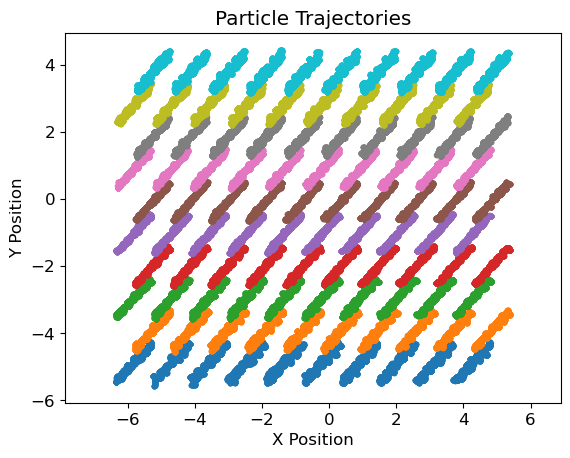

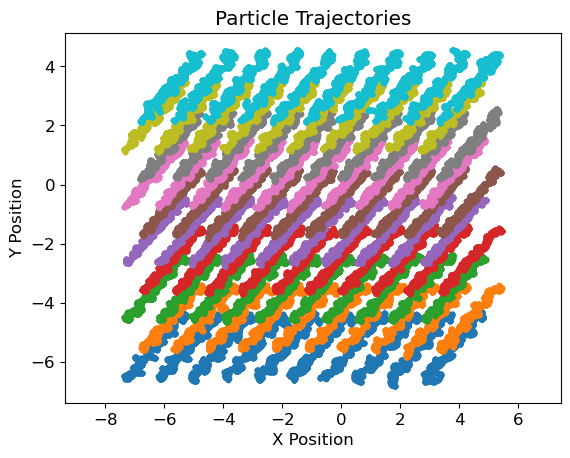

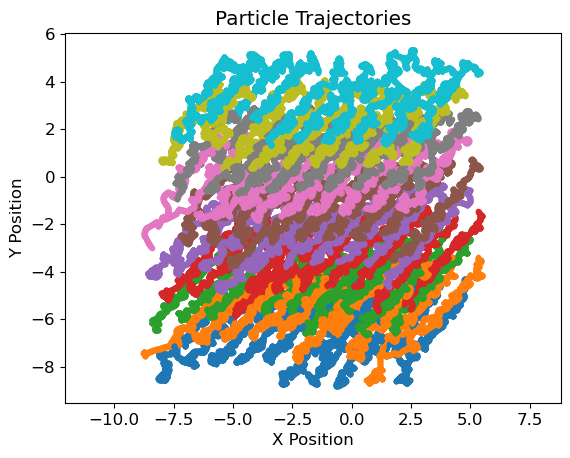

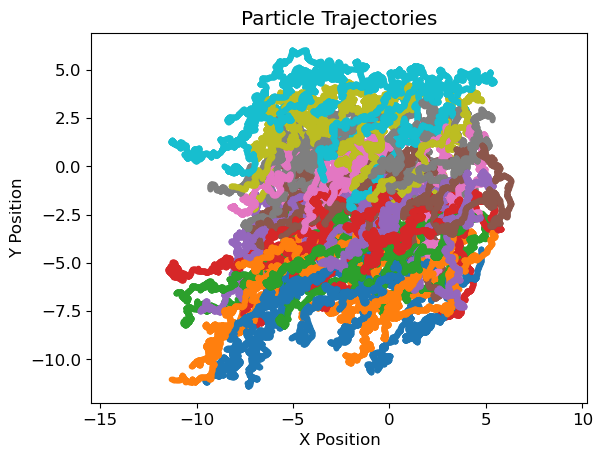

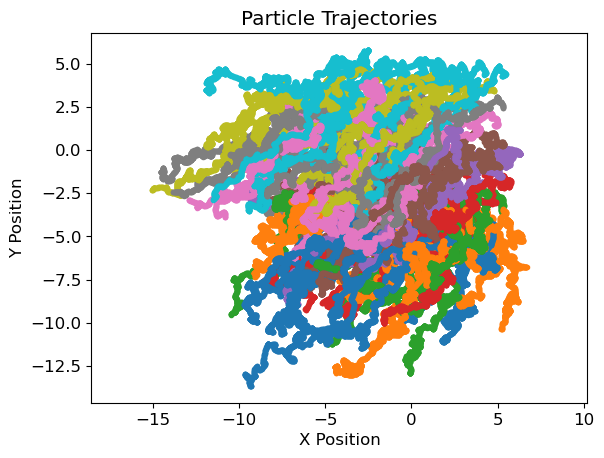

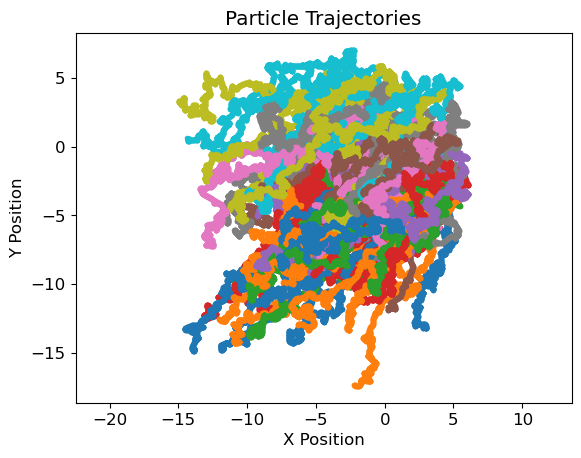

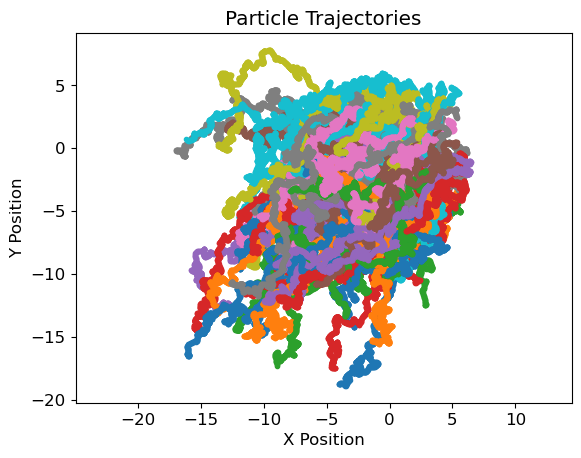

In [62]:
for trajectory in trajectories.values():
    plot_traj(trajectory, L)




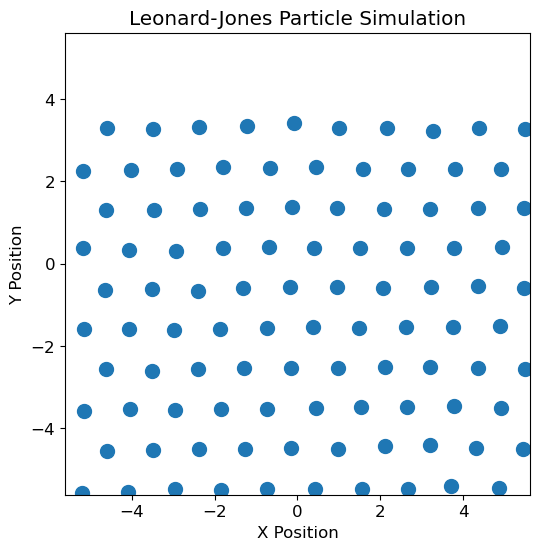

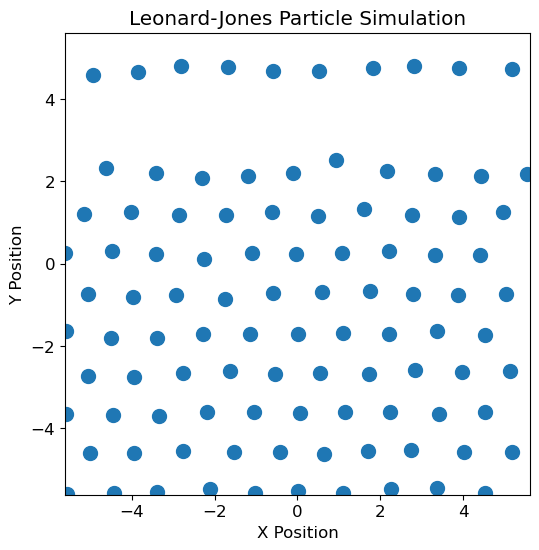

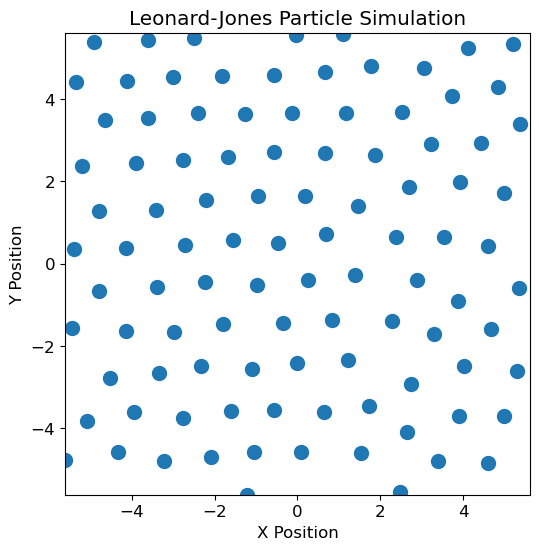

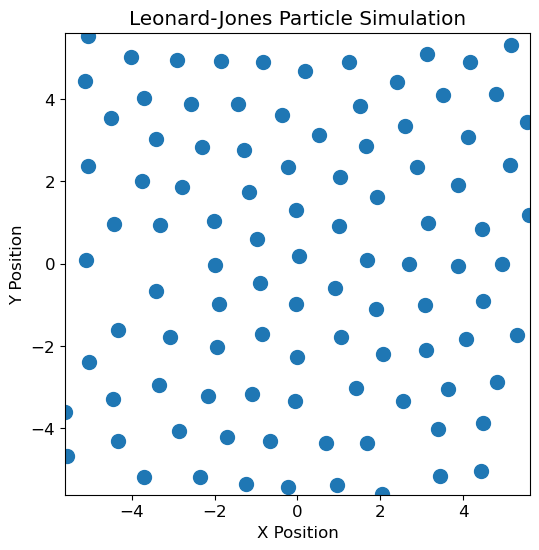

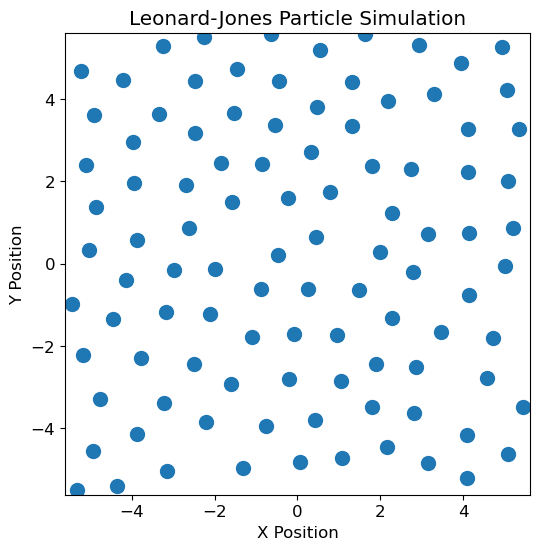

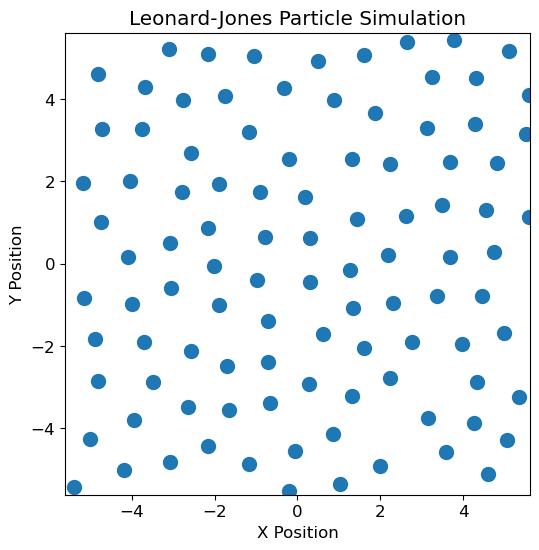

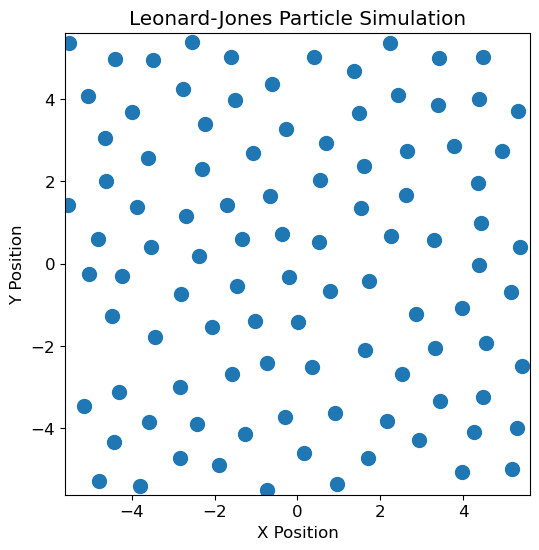

In [63]:
for trajectory in trajectories.values():
    animate_trajectory(trajectory, L)

# Question 4

At low initial speeds, the lattice maintains its shape. As the initial speed increases, the lattice starts to break and the L-J particles are freely moving.

# Question 5

 The equlibration lines makes sense after the v_init > 1.0. These equilibration lines makes sense as they are first indicated where the temperature oscillates around one value. There are no huge jumps in the data after the equilibration steps. However if v_init <= 1.0, the equilibration line is indicated where the simulation starts, so around t=0. These lines do not make sense since the simulation has just started, but assumes it has already equilibrated instantaneously. 

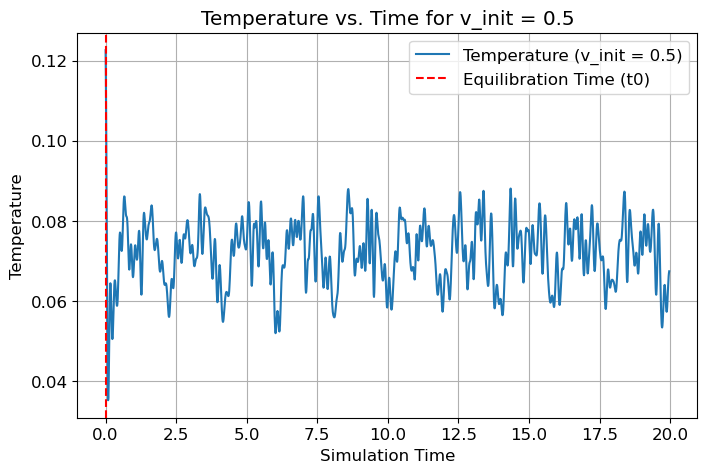

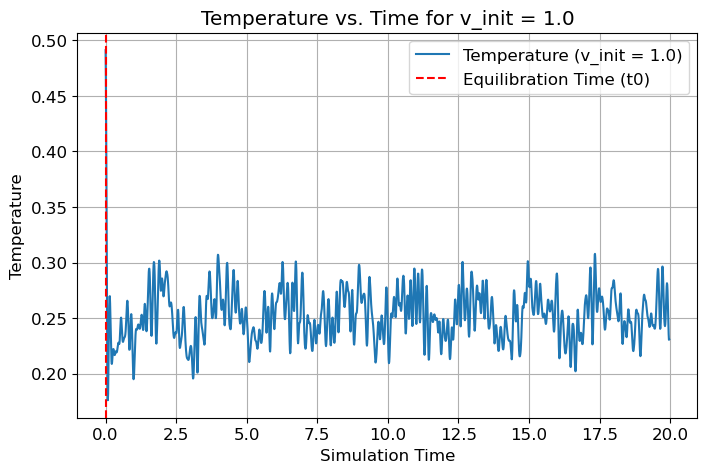

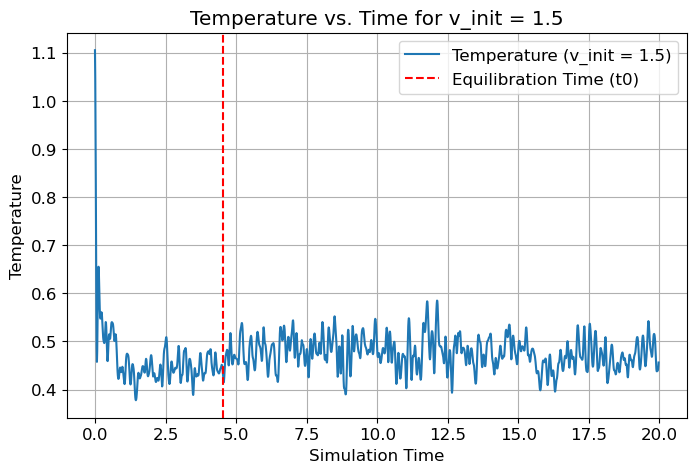

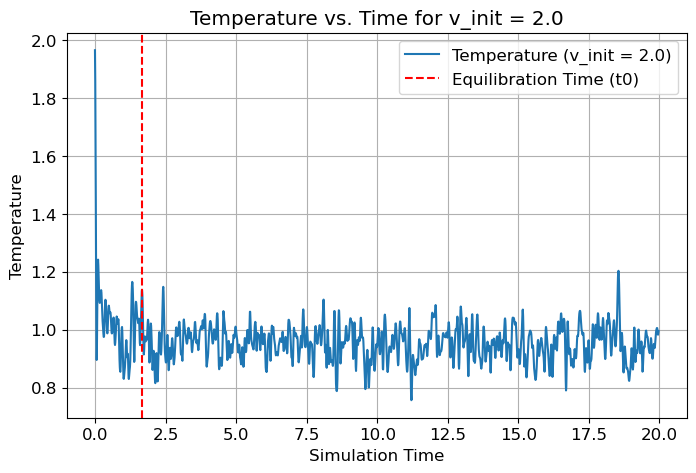

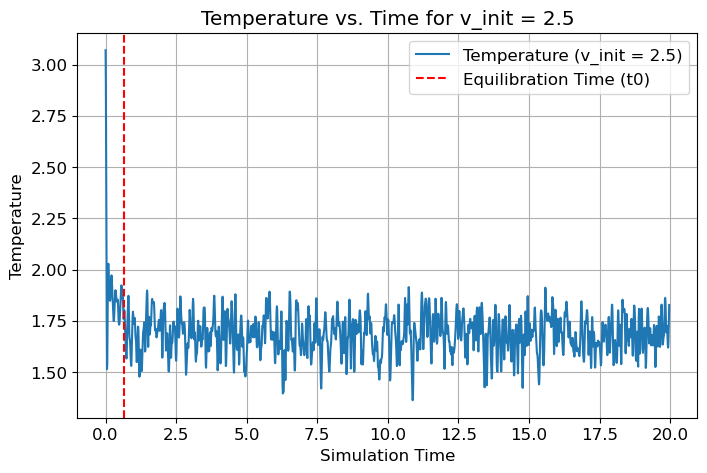

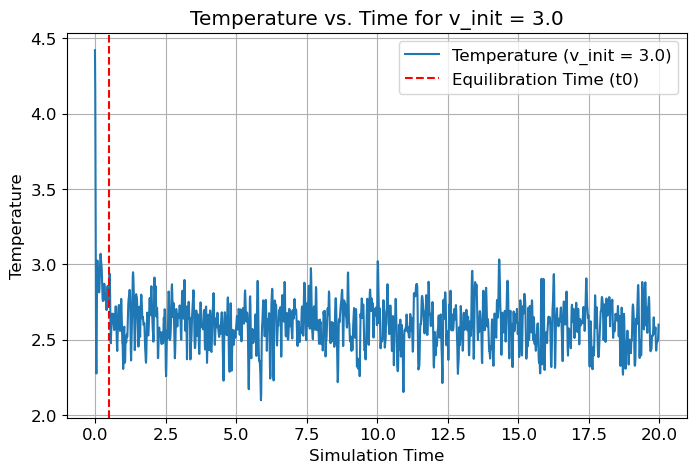

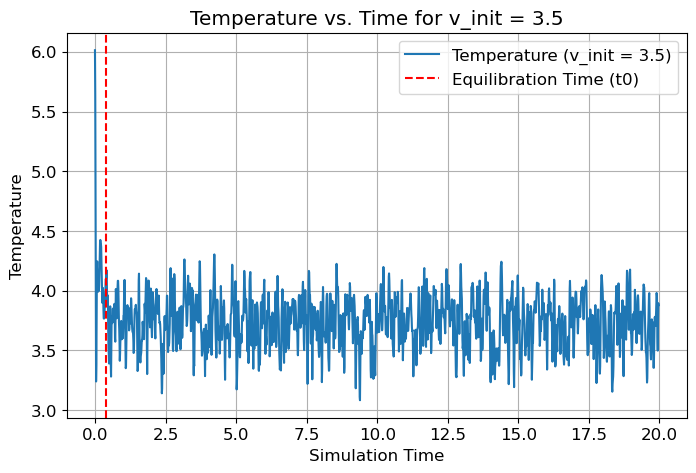

In [64]:
def plot_Temp_vs_time(trajectories, dt):
    '''Plotting the Temperature vs time'''
    

    for v_init, trajectory in trajectories.items():
        T_values = calc_temp(trajectory, dt)  # Compute temperature
        time_values = np.arange(len(T_values)) * dt  # Convert steps to real time
        
        # Detect equilibration time
        t0_index, _, _ = pt.detect_equilibration(T_values)
        t0_actual = t0_index * dt  # Convert index to actual time

        # Create individual figure for each v_init
        plt.figure(figsize=(8, 5))
        plt.plot(time_values, T_values, label=f"Temperature (v_init = {v_init})")
        plt.axvline(t0_actual, color="red", linestyle="--", label=f"Equilibration Time (t0)")
        
        plt.xlabel("Simulation Time")
        plt.ylabel("Temperature")
        plt.title(f"Temperature vs. Time for v_init = {v_init}")
        plt.legend()
        plt.grid()
        plt.show()



plot_Temp_vs_time(trajectories, dt)



    

# Question 6 (Speed Distribution)

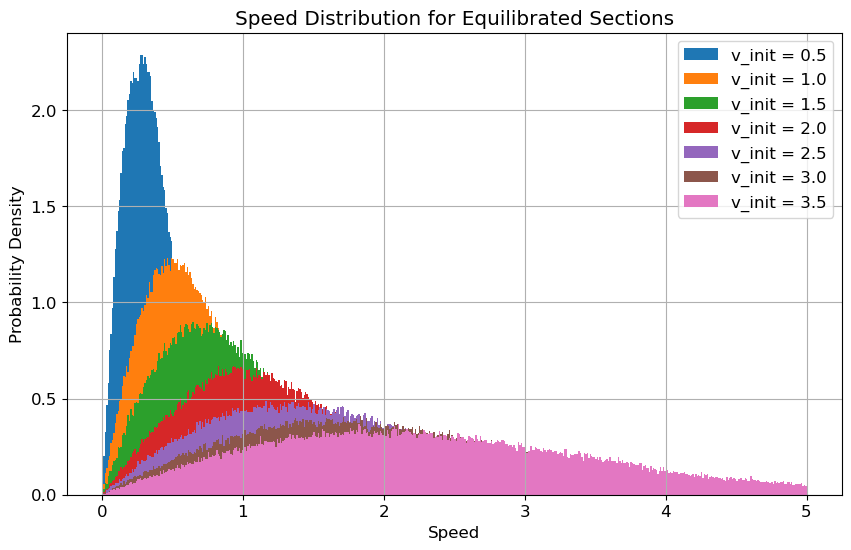

In [65]:
speed_distribution(trajectories, dt, v_max=5, dv=0.01)

# Question 7 (2D - Maxwell Boltzmann)

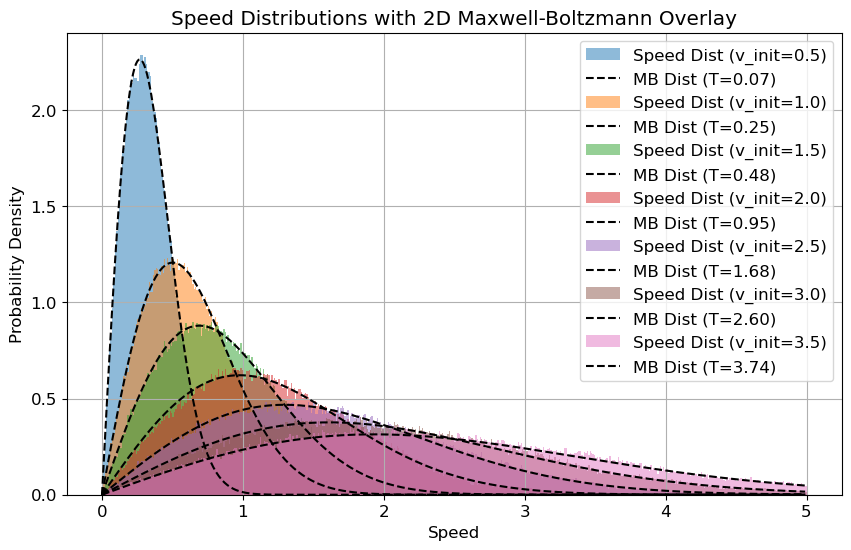

In [66]:
def speed_distribution_overlay(trajectories, mean_temperatures, dt, v_max, dv):
    """Overlays speed distributions with 2D Maxwell-Boltzmann distributions using mean equilibration temperatures."""
    
    k_b = 1.0

    plt.figure(figsize=(10, 6))

    for v_init, trajectory in trajectories.items():
        T_mean = mean_temperatures[v_init]

        # Compute speed distribution + histogram
        velocities = (trajectory[2:] - trajectory[:-2]) / (2 * dt)
        speeds = np.linalg.norm(velocities, axis=-1).flatten()
        bins = np.arange(0, v_max + dv, dv)
        plt.hist(speeds, bins=bins, density=True, alpha=0.5, label=f"Speed Dist (v_init={v_init})")

        # Compute Maxwell-Boltzmann distribution
        v_list = np.arange(0, v_max, dv)
        MB_dist = (v_list / (k_b * T_mean)) * np.exp(-v_list**2 / (2 * k_b * T_mean))

        #Overlay MB distribution as a black dotted line
        plt.plot(v_list, MB_dist, "k--", label=f"MB Dist (T={T_mean:.2f})")

    plt.xlabel("Speed")
    plt.ylabel("Probability Density")
    plt.title("Speed Distributions with 2D Maxwell-Boltzmann Overlay")
    plt.legend()
    plt.grid()
    plt.show()

mean_temperatures = {}

for v_init, trajectory in trajectories.items():
    t0_index, _, _ = pt.detect_equilibration(calc_temp(trajectory, dt))  
    T_mean = np.mean(calc_temp(trajectory[t0_index:], dt))  
    mean_temperatures[v_init] = T_mean  # Store mean temperature

v_max = 5
dv = 0.01

speed_distribution_overlay(trajectories, mean_temperatures, dt, v_max, dv)

# Question 8

C:\Users\mo241\AppData\Local\Temp\ipykernel_13828\606405066.py:4: RuntimeWarning: divide by zero encountered in divide
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation
C:\Users\mo241\AppData\Local\Temp\ipykernel_13828\606405066.py:4: RuntimeWarning: invalid value encountered in add
  FRR = 4 * epsilon * (-12 * (sigma / rij) ** 13 + 6*(sigma/rij)**7) / sigma #LJ Force equation


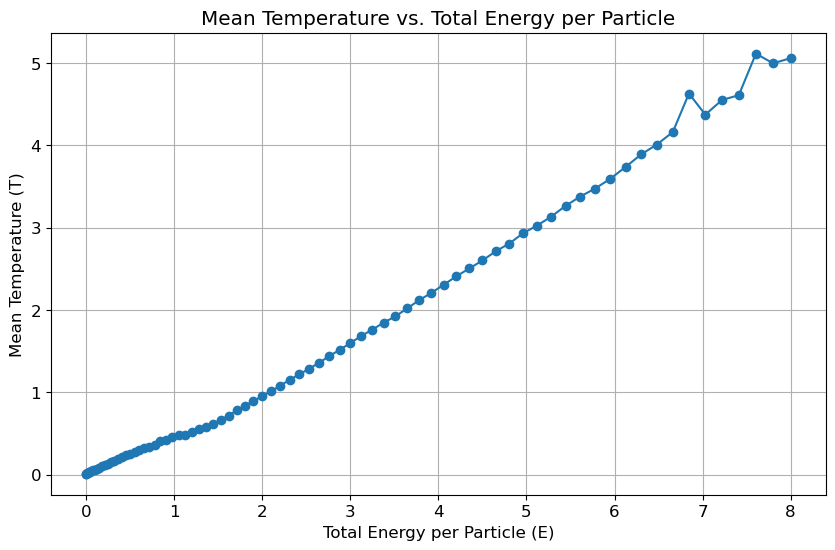

In [67]:
#Smaller initial velocity spacings

v_init_small = np.arange(0.05, 4.05, 0.05)

num_v = len(v_init_small)
T_fine = np.zeros(num_v)  
E_fine = np.zeros(num_v)  


positions = shift(make_triangular_lattice(np.array([0, 0]), N, 2**(1/6)), L)

for i, v_init in enumerate(v_init_small):

    velocities = v_init * create_unit_vectors(N*N, seed=20)

    trajectory, _ = simulation(R_0=positions, v_0=velocities, m=masses, t=0.01, t_max=20, sigma=1, epsilon=1, L=L)


    #Compute mean temperature after equilibration
    t0_index, _, _ = pt.detect_equilibration(calc_temp(trajectory, dt))
    T_fine[i] = np.mean(calc_temp(trajectory[t0_index:], dt))


    #Compute total energy per particle (KE), assume PE=0
    ke_values = 0.5 * (np.sum(velocities**2, axis=1))
    E_fine[i] = ke_values[0]  # Compute energy

#Plot mean temperature vs. total energy per particle
plt.figure(figsize=(10, 6))
plt.plot(E_fine, T_fine, marker="o", linestyle="-")
plt.xlabel("Total Energy per Particle (E)")
plt.ylabel("Mean Temperature (T)")
plt.title("Mean Temperature vs. Total Energy per Particle")
plt.grid()
plt.show()

# Question 9 (Specific Heat)

In the plot, there is a discontinuity that is represented as a spike. This can indicate that a phase transition occurs from where the lattice breaks and the L-J particles are freely moving. 

There are also discontinuities as v_init approaches 4.0, but this can indicate can break at these higher initial velocities. Or it has entered another phase transition since the interparticle distance between particles are greater with higher initial velocities.

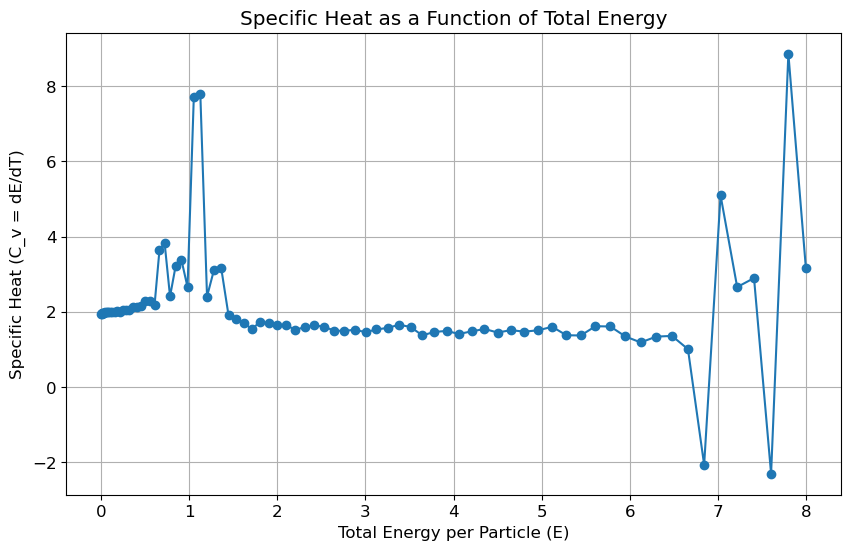

In [69]:
C_v = np.gradient(E_fine, T_fine)
# Plot specific heat vs. total energy per particle
plt.figure(figsize=(10, 6))
plt.plot(E_fine, C_v, marker="o", linestyle="-")

plt.xlabel("Total Energy per Particle (E)")
plt.ylabel("Specific Heat (C_v = dE/dT)")
plt.title("Specific Heat as a Function of Total Energy")
plt.grid()
plt.show()